# Datasets

We use Google Drive to share the data used for training the model and the model already trained. To add a shortcut to the location of the data in your Google Drive, follow these steps:    

* Go to https://drive.google.com/drive/folders/1EPfe4G6Y32c6eTrM6gnTjxr7KUlrGwAt?usp=sharing
* Click in "MAPBIOMAS-PUBLIC" &#8594; "Add Shortcut to Drive" &#8594; "My Drive" &#8594; "ADD SHORTCUT"

## Mount Google Drive

After adding the shortcut to the data in your Google Drive, the next step is to mount a Google Drive volume on Google Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!du -h -d 3 /content/drive/My\ Drive/MAPBIOMAS-PUBLIC/

665M	/content/drive/My Drive/MAPBIOMAS-PUBLIC/collection_5/center_pivot_irrigation/train
176M	/content/drive/My Drive/MAPBIOMAS-PUBLIC/collection_5/center_pivot_irrigation/test
55M	/content/drive/My Drive/MAPBIOMAS-PUBLIC/collection_5/center_pivot_irrigation/predict
321M	/content/drive/My Drive/MAPBIOMAS-PUBLIC/collection_5/center_pivot_irrigation/logs
1.5G	/content/drive/My Drive/MAPBIOMAS-PUBLIC/collection_5/center_pivot_irrigation
1.5G	/content/drive/My Drive/MAPBIOMAS-PUBLIC/collection_5
4.0K	/content/drive/My Drive/MAPBIOMAS-PUBLIC/collection_6/citrus/predict
319M	/content/drive/My Drive/MAPBIOMAS-PUBLIC/collection_6/citrus/logs
4.0K	/content/drive/My Drive/MAPBIOMAS-PUBLIC/collection_6/citrus/test
114M	/content/drive/My Drive/MAPBIOMAS-PUBLIC/collection_6/citrus/train
432M	/content/drive/My Drive/MAPBIOMAS-PUBLIC/collection_6/citrus
119M	/content/drive/My Drive/MAPBIOMAS-PUBLIC/collection_6/irrigated_rice/rice_logs_MAPBIOMAS
4.0K	/content/drive/My Drive/MAPBIOMAS-PUBLIC/collectio

Information about directories and files:

* collection_6/citrus/train → contains images ending in "_mosaic.tif", with 3 bands, and images ending in "_labels.tif", with 1 band. For each image ending in "_mosaic.tif", which we use as an entry for the model, there is an image with the same prefix, but ending in "_labels.tif" containing the ground truth used to adjust the model;

* collection_6/citrus/test → follows the same structure as before, but with images that were used to test the model after the training process;

* collection_6/citrus/predict → example image that we can use, after training the model or using our trained model, to map the central pivot irrigation systems;

* collection_6/citrus/logs → trained model and log files generated in the training process.

## Check GPU

We recommend that the entire model and classification training process be done using some of the GPUs available from Google Colab.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Aug 24 19:42:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install requirements

Install GDAL

In [ ]:
#Step 1
!apt-get update
#Step 2
!apt-get install libgdal-dev -y
#Step 3
!apt-get install python-gdal -y

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad

## Configure Enviroment

In [ ]:
import random
import numpy as np
seed = 426
random.seed(seed)
np.random.seed = seed

## Settings

In [ ]:
CHIP_SIZE = 256
CHANNELS = 3
LABELS = [0, 1]
SPATIAL_SCALE = 30
PROJECTION = 3857

# Build Datasets
GRIDS = 2
ROTATE = True
FLIP = True

PUBLIC_ROOT_DIR = "/content/drive/My Drive/MAPBIOMAS-PUBLIC/collection_6/citrus"
PRIVATE_ROOT_DIR = "/content/drive/My Drive/MAPBIOMAS-PRIVATE-CITRUS"
DATASET_DIR = "/content"

TRAIN_VALIDATION_DIR = f"${PUBLIC_ROOT_DIR}/train"
TEST_DIR = f"${PUBLIC_ROOT_DIR}/test"
TRAIN_PATH = f"${DATASET_DIR}/train.h5"
VALIDATION_PATH = f"${DATASET_DIR}/validation.h5"
TEST_PATH = f"${DATASET_DIR}/test.h5"

# Train model
# in case of error during training, decrease the value of TRAIN_BATCH_SIZE
TRAIN_BATCH_SIZE = 20
TRAIN_EPOCHS = 100

# Predict images
PREDICT_INPUT_DIR = f"${PRIVATE_ROOT_DIR}"
PREDICT_OUPUT_DIR = f"${PRIVATE_ROOT_DIR}/RESULTS"
PREDICT_CHIP_SIZE = 1024
PREDICT_GRIDS = 3
PREDICT_BATCH_SIZE = 1

# Load trained model
MODEL_DIR = f"${PUBLIC_ROOT_DIR}/logs"

## Image Utils

In [ ]:
# -*- encoding=UTF-8-*-

import gc
import os

import h5py
import numpy as np
import psutil
from osgeo import gdal, osr
from skimage.transform import resize, rotate
from sklearn.model_selection import train_test_split
from tqdm import tqdm


def load_file(path, resizeTo=None, norm=False):
    # dataSource = gdal.Open(path)
    dataSource = reproject_dataset(path, pixel_spacing=30, epsg_to=PROJECTION)

    if not dataSource is None:
        bands = []
        for index in range(1, dataSource.RasterCount + 1):
            band = dataSource.GetRasterBand(index).ReadAsArray()
            if norm:
                normalized_band = normalize(band)
                bands.append(normalized_band)
            else:
                bands.append(band)

        image = np.dstack(bands)

        return image
    else:
        return None

def reproject_dataset ( dataset, pixel_spacing=30., epsg_to=3857 ):
    """
    A sample function to reproject and resample a GDAL dataset from within 
    Python. The idea here is to reproject from one system to another, as well
    as to change the pixel size. The procedure is slightly long-winded, but
    goes like this:
    
    1. Set up the two Spatial Reference systems.
    2. Open the original dataset, and get the geotransform
    3. Calculate bounds of new geotransform by projecting the UL corners 
    4. Calculate the number of pixels with the new projection & spacing
    5. Create an in-memory raster dataset
    6. Perform the projection
    """
    # We now open the dataset
    g = gdal.Open ( dataset )

    # Define the UK OSNG, see <http://spatialreference.org/ref/epsg/27700/>
    osng = osr.SpatialReference ()
    osng.ImportFromEPSG ( epsg_to )

    wkt = g.GetProjection()
    wgs84 = osr.SpatialReference ()
    wgs84.ImportFromWkt(wkt)

    tx = osr.CoordinateTransformation ( wgs84, osng )
    # Up to here, all  the projection have been defined, as well as a 
    # transformation from the from to the  to :)

    # Get the Geotransform vector
    geo_t = g.GetGeoTransform ()
    x_size = g.RasterXSize # Raster xsize
    y_size = g.RasterYSize # Raster ysize
    # Work out the boundaries of the new dataset in the target projection
    (ulx, uly, ulz ) = tx.TransformPoint( geo_t[0], geo_t[3])
    (lrx, lry, lrz ) = tx.TransformPoint( geo_t[0] + geo_t[1]*x_size, \
                                          geo_t[3] + geo_t[5]*y_size )
    # See how using 27700 and WGS84 introduces a z-value!
    # Now, we create an in-memory raster
    mem_drv = gdal.GetDriverByName( 'MEM' )
    # The size of the raster is given the new projection and pixel spacing
    # Using the values we calculated above. Also, setting it to store one band
    # and to use Float32 data type.
    dest = mem_drv.Create('', int((lrx - ulx)/pixel_spacing), \
            int((uly - lry)/pixel_spacing), g.RasterCount, gdal.GDT_Float32)
    # Calculate the new geotransform
    new_geo = ( ulx, pixel_spacing, geo_t[2], \
                uly, geo_t[4], -pixel_spacing )
    # Set the geotransform
    dest.SetGeoTransform( new_geo )
    dest.SetProjection ( osng.ExportToWkt() )
    # Perform the projection/resampling 
    res = gdal.ReprojectImage( g, dest, \
                wgs84.ExportToWkt(), osng.ExportToWkt(), \
                gdal.GRA_Bilinear )
    return dest

def normalize(image):
    image_max = float(np.max(image))
    image_min = float(np.min(image))
    normalized = (image - image_min) / (image_max - image_min)

    del image
    gc.collect()
    return normalized


def get_rotate(image):
    images = []
    for rot in [90, 180, 270]:
        image_rotate = rotate(image, rot, preserve_range=True)
        images.append(image_rotate)

    del image
    gc.collect()
    return images


def get_flip(image):
    horizontal_flip = image[:, ::-1]
    vertical_flip = image[::-1, :]

    del image
    gc.collect()
    return [horizontal_flip, vertical_flip]


def load_dataset(dataset, read_only=False):
    if read_only:
        dataset = h5py.File(dataset, 'r')
    else:
        dataset = h5py.File(dataset, 'r+')
    x_data = dataset["x"]
    y_data = dataset["y"]
    return dataset, x_data, y_data


def make_dataset(filename, width, height, channels):
    dataset = h5py.File(filename, 'w')
    x_data = dataset.create_dataset("x", (0, width, height, channels), 'f',
                                    maxshape=(None, width, height, channels),
                                    chunks=True
                                    # , compress="gzip"
                                    )
    y_data = dataset.create_dataset("y", (0, width, height, 1), 'f',
                                    maxshape=(None, width, height, 1),
                                    chunks=True
                                    # , compress="gzip"
                                    )
    return dataset, x_data, y_data


def get_available_memory():
    return 100 - psutil.virtual_memory().percent


def chip_is_empty(chip):
    labels_unique = np.unique(chip)
    if 0 in labels_unique and len(labels_unique) == 1:
        return True
    else:
        return False


def generate_dataset(image_path, labels_path, train_path, validation_path, 
                     chip_size, channels, grids=1, rotate=False, flip=False):
    image_data = load_file(image_path, norm=True)
    image_labels = load_file(labels_path)

    # resize labels
    image_labels = resize(image_labels,
                          (image_data.shape[0], image_data.shape[1]),
                          preserve_range=True, anti_aliasing=True).astype(np.int8)

    image = np.dstack([image_data, image_labels])

    # pad image to avoid the loss of border samples
    del image_data
    del image_labels
    gc.collect()

    X_set = []
    y_set = []
    for step in get_grids(grids, chip_size):
        for (x, y, window, dimension) in sliding_window(image,
                                                        step["steps"],
                                                        step["chip_size"],
                                                        (
                                                                chip_size,
                                                                chip_size)):
            
            train = np.array(window[:, :, : channels], dtype=np.float16)
            labels = np.array(window[:, :, -1:], dtype=np.int8)

            if not chip_is_empty(labels):
                raw_image = np.dstack([train, labels])
                images_daugmentation = [raw_image]

                if rotate:
                    images_rotate = get_rotate(raw_image)
                    images_daugmentation.extend(images_rotate)

                if flip:
                    images_flip = []
                    for im in images_daugmentation:
                        images_flip.extend(get_flip(im))
                    images_daugmentation.extend(images_flip)

                for i in images_daugmentation:
                    new_train = np.array(i[:, :, :channels], dtype=np.float16)
                    new_labels = np.array(i[:, :, -1:], dtype=np.int8)

                    np.clip(new_labels, 0, None, out=new_labels)
                    X_set.append(new_train)
                    y_set.append(new_labels)
        
        print("\nAll:", len(X_set))

        if len(X_set) >= 5:
            X_train, X_val, y_train, y_val = train_test_split(X_set, y_set, test_size=0.25, random_state=1)
            
            print("X_train:", len(X_train))
            print("X_val:", len(X_val))

            save_dataset(X_train, y_train, train_path, chip_size, channels)
            save_dataset(X_val, y_val, validation_path, chip_size, channels)


def save_dataset(X, y, output_path, chip_size, channels):
    if os.path.isfile(output_path):
        dataset, x_data, y_data = load_dataset(output_path)
    else:
        dataset, x_data, y_data = make_dataset(output_path, chip_size,
                                               chip_size, channels)

    length = len(X)

    x_data_size = x_data.len()
    y_data_size = y_data.len()

    x_data.resize((x_data_size + length, chip_size, chip_size, channels))
    y_data.resize((y_data_size + length, chip_size, chip_size, 1))

    print("Saving dataset...")
    
    x_data[x_data_size:] = X
    y_data[y_data_size:] = y
    
    dataset.close()
    del x_data
    del y_data
    gc.collect()


def sliding_window(image, step, chip_size, chip_resize):
    # slide a chip across the image
    step_cols = int(step[0])
    step_rows = int(step[1])

    cols = image.shape[1]
    rows = image.shape[0]

    chip_size_cols = chip_size[0]
    chip_size_rows = chip_size[1]

    chip_resize_cols = chip_resize[0]
    chip_resize_rows = chip_resize[1]

    for y in range(0, rows, step_rows):
        for x in range(0, cols, step_cols):

            origin_x = x
            origin_y = y

            if (origin_y + chip_size_rows) > rows:
                origin_y = rows - chip_size_rows

            if (origin_x + chip_size_cols) > cols:
                origin_x = cols - chip_size_cols

            chip = image[origin_y:origin_y + chip_size_rows,
                   origin_x: origin_x + chip_size_cols]

            original_shape = chip.shape

            if chip.shape != (chip_resize_cols, chip_resize_rows):
                chip = resize(chip,
                              (chip_resize_cols, chip_resize_rows),
                              preserve_range=True,
                              anti_aliasing=True).astype(np.float16)

            yield (origin_x, origin_y, chip, original_shape)


def get_window(matrix, x, y, width, height):
    return matrix[y:y + height, x:x + width]


def set_window(matrix, x, y, new_matrix):
    for i_index, i in enumerate(range(y, y + new_matrix.shape[0])):
        for j_index, j in enumerate(range(x, x + new_matrix.shape[1])):
            matrix[i][j] = new_matrix[i_index][j_index]


def get_grids(grids, chip_size):
    # multiplying chip_size by 1.5 to prevent missing data in rotation
    grids_dict = {
        1: [
            {"steps": (chip_size, chip_size),
             "chip_size": (chip_size, chip_size)}
        ],
        2: [
            {"steps": (int(chip_size * 0.5), int(chip_size * 0.5)),
             "chip_size": (chip_size, chip_size)},
        ],
        3: [
            {"steps": (int(chip_size * 0.9), int(chip_size * 0.9)),
             "chip_size": (chip_size, chip_size)},
        ]
    }

    return grids_dict[grids]

## Model

### Evaluation Metrics

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32') # .5 is the threshold
    inter = K.sum(K.sum(K.squeeze(y_true * y_pred, axis=3), axis=2), axis=1)
    union = K.sum(K.sum(K.squeeze(y_true + y_pred, axis=3), axis=2), axis=1) - inter
    acc = K.mean((inter + K.epsilon()) / (union + K.epsilon()))
    return acc

### U-Net

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation


def conv(n_filters, kernel_size, activation='elu', inputs=None):
    net = Conv2D(n_filters, kernel_size, activation=None, kernel_initializer='he_normal', padding='same') (inputs) 
    net = BatchNormalization()(net)
    net = Activation(activation)(net)
    return net

def transpose(n_filters, kernel_size, activation='elu', inputs=None):
    net = Conv2DTranspose(n_filters, kernel_size, activation=None, strides=(2, 2), padding='same', kernel_initializer='he_normal') (inputs)
    net = BatchNormalization()(net)
    net = Activation(activation)(net)
    return net

def model_fn(input_shape, n_filters=64):
    inputs = keras.Input(input_shape)

    c1 = conv(n_filters * 1, (3, 3), inputs=inputs)
    c1 = conv(n_filters * 1, (3, 3), inputs=c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(0.25) (p1)

    c2 = conv(n_filters * 2, (3, 3), inputs=p1)
    c2 = conv(n_filters * 2, (3, 3), inputs=c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(0.25) (p2)

    c3 = conv(n_filters * 4, (3, 3), inputs=p2)
    c3 = conv(n_filters * 4, (3, 3), inputs=c3)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(0.5) (p3)

    c4 = conv(n_filters * 8, (3, 3), inputs=p3)
    c4 = conv(n_filters * 8, (3, 3), inputs=c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(0.5) (p4)

    c5 = conv(n_filters * 16, (3, 3), inputs=p4)
    c5 = conv(n_filters * 16, (3, 3), inputs=c5)
    c5 = Dropout(0.5) (c5)

    u6 = transpose(n_filters * 8, (2, 2), inputs=c5)
    u6 = concatenate([u6, c4])
    c6 = conv(n_filters * 8, (2, 2), inputs=u6)
    c6 = conv(n_filters * 8, (2, 2), inputs=c6)
    c6 = Dropout(0.5) (c6)
    
    u7 = transpose(n_filters * 4, (2, 2), inputs=c6)
    u7 = concatenate([u7, c3])
    c7 = conv(n_filters * 4, (2, 2), inputs=u7)
    c7 = conv(n_filters * 4, (2, 2), inputs=c7)
    c7 = Dropout(0.5) (c7)

    u8 = transpose(n_filters * 2, (2, 2), inputs=c7)
    u8 = concatenate([u8, c2])
    c8 = conv(n_filters * 2, (2, 2), inputs=u8)
    c8 = conv(n_filters * 2, (2, 2), inputs=c8)
    c8 = Dropout(0.25) (c8)
    
    u9 = transpose(n_filters * 1, (2, 2), inputs=c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv(n_filters * 1, (2, 2), inputs=u9)
    c9 = conv(n_filters * 1, (2, 2), inputs=c9)
    c9 = Dropout(0.25) (c9)

    outputs = conv(1, (1, 1), activation='sigmoid', inputs=c9)

    model = keras.Model(inputs=inputs, outputs=outputs)

    # começa o treinamento com 0.01, depois de perceber que estáá começando a ficar instáável, 
    # altera para 0.0001
    optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0001) # 0.01 or 0.0001

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[iou])

    return model

## Classifier

In [ ]:
import numpy as np
import tensorflow as tf
from osgeo import gdal
from tqdm import tqdm

class Classifier(object):
    def __init__(self, model, model_dir):
        self.__model = model
        self.__model.summary()

        checkpoint_path = "{dir}/model.ckpt".format(dir=model_dir)

        latest = tf.train.latest_checkpoint(model_dir)

        if latest:
            model.load_weights(latest)

        cp_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            save_weights_only=True,
            save_best_only=True)

        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=model_dir)

        self.__callbacks = [cp_callback, tensorboard_callback]

    def train(self, input_train, input_validation, epochs, batch_size):
        train_file, train_data, train_labels = load_dataset(input_train, read_only=True)
        validation_file, validation_data, validation_labels = load_dataset(input_validation, read_only=True)

        train_images = np.asarray(train_data[:8000], dtype=np.float16)
        train_labels = np.asarray(train_labels[:8000], dtype=np.int8)
        
        validation_images = np.asarray(validation_data[:2000], dtype=np.float16)
        validation_labels = np.asarray(validation_labels[:2000], dtype=np.int8)
        
        print("\nTrain: {0}\n".format(train_images.shape[0]))
        print("Validation: {0}\n".format(validation_images.shape[0]))

        return self.__model.fit(x=train_images, 
                         y=train_labels,
                         validation_data=(validation_images, validation_labels),
                         epochs=epochs,
                         batch_size=batch_size,
                         verbose=1,
                         callbacks=self.__callbacks,
                         shuffle=True)

    

    def evaluate(self, input_test, batch_size):
        test_file, test_data, test_labels = load_dataset(input_test, read_only=True)

        test_data = np.asarray(test_data, dtype=np.float16)
        test_labels = np.asarray(test_labels, dtype=np.int8)

        test_results = self.__model.evaluate(test_data,
                                             test_labels,
                                             batch_size=batch_size)
        
        print('test loss, test acc:', test_results)

    def predict(self, input_path, output_path, chip_size, channels, grids, batch_size):

        input_dataset = gdal.Open(input_path)

        image = load_file(input_path, norm=True)[:, :, :channels]

        predicted_image = np.zeros((image.shape[0], image.shape[1]), dtype=np.int8)

        grids = get_grids(grids, chip_size)

        for step in grids:
            batch = []
            windows = sliding_window(image, step["steps"], step["chip_size"],
                (chip_size, chip_size))

            for (x, y, chip, original_dimensions) in tqdm(iterable=windows,
                                                          miniters=10,
                                                          unit=" windows"):

                normalized_chip = normalize(chip)

                batch.append({
                    "chip": normalized_chip,
                    "x": x,
                    "y": y,
                    "dimensions": original_dimensions
                })

                if len(batch) >= batch_size:
                    chips = []
                    positions = []
                    dimensions = []

                    for b in batch:
                        chips.append(b.get("chip"))
                        positions.append((b.get("x"), b.get("y")))
                        dimensions.append(b.get("dimensions"))

                    chips = np.array(chips, dtype=np.float16)

                    pred = self.__model.predict(chips)

                    for chip, position, dimension, predict in zip(chips,
                                                                  positions,
                                                                  dimensions,
                                                                  pred):
                        predict[predict > 0.5] = 1
                        predict[predict <= 0.5] = 0

                        predict = resize(predict, (dimension[0], dimension[1]),
                            preserve_range=True,
                            anti_aliasing=True).astype(np.int8)

                        predict = predict.reshape(
                            (predict.shape[0], predict.shape[1]))

                        predicted = get_window(predicted_image,
                                               position[0],
                                               position[1],
                                               predict.shape[1],
                                               predict.shape[0])

                        if predict.shape != predicted.shape:
                            raise Exception("predict.shape != predicted.shape")

                        set_window(predicted_image,
                                   position[0],
                                   position[1],
                                   np.add(predict, predicted))
                    batch = []
            print("Saving results...")
            driver = input_dataset.GetDriver()
            output_dataset = driver.Create(output_path,
                                           image.shape[1],
                                           image.shape[0],
                                           1,
                                           gdal.GDT_Int16,
                                           ['COMPRESS=DEFLATE'])
            output_dataset.SetGeoTransform(input_dataset.GetGeoTransform())
            output_dataset.SetProjection(input_dataset.GetProjection())
            output_dataset.GetRasterBand(1) \
                .WriteArray(predicted_image.reshape((predicted_image.shape[0],
                                                     predicted_image.shape[1])
                                                    ), 0, 0)
            output_dataset.FlushCache()
            output_dataset = None
            print("The results have been saved!")

# Use Our Trained Model

In [ ]:
from os import listdir
from os.path import isfile, join, sep, exists

model = model_fn((PREDICT_CHIP_SIZE, PREDICT_CHIP_SIZE, CHANNELS))

classifier = Classifier(model=model, model_dir=MODEL_DIR)

if not os.path.exists(PREDICT_INPUT_DIR):
    print("Please wait until Google Earth Engine finishes processing your task.")

files = [f for f in listdir(PREDICT_INPUT_DIR) if isfile(join(PREDICT_INPUT_DIR, f))]

if len(files) == 0:
    print("No file found.")

for f in files:
    print("File:", f)
    input_file = "{directory}{sep}{filepath}".format(directory=PREDICT_INPUT_DIR,
                                                     sep=sep,
                                                     filepath=f)

    output_file = "{directory}{sep}{filepath}".format(directory=PREDICT_OUPUT_DIR,
                                                      sep=sep,
                                                      filepath=f)

    if not os.path.exists(PREDICT_OUPUT_DIR):
            os.makedirs(PREDICT_OUPUT_DIR)

    if exists(output_file):
        print("File {} exists.".format(output_file))
        continue
        
    print("Predict: ", input_file, "  >>  ", output_file)

    classifier.predict(
        input_path=input_file,
        output_path=output_file,
        chip_size=PREDICT_CHIP_SIZE,
        channels=CHANNELS,
        grids=PREDICT_GRIDS,
        batch_size=PREDICT_BATCH_SIZE
    )

In [ ]:
gc.collect()

del model
del classifier

gc.collect()

# Train Your Own Model

## Build Train and Validation datasets

In [ ]:
import glob

mosaics = [f for f in glob.glob(TRAIN_VALIDATION_DIR + "/MOSAIC_*.tif", recursive=True)]

if len(mosaics) == 0:
    print("No samples found.")

for mosaic_path in mosaics:
    labels_path = mosaic_path.replace("MOSAIC", "LABELS")
    print(mosaic_path)
    print(labels_path)
    generate_dataset(
        image_path=mosaic_path,
        labels_path=labels_path,
        train_path=TRAIN_PATH,
        validation_path=VALIDATION_PATH,
        chip_size=CHIP_SIZE,
        channels=CHANNELS,  
        grids=GRIDS,
        rotate=ROTATE,
        flip=FLIP
    )

/content/drive/My Drive/MAPBIOMAS-PUBLIC/collection_6/citrus/train/MOSAIC_0.tif
/content/drive/My Drive/MAPBIOMAS-PUBLIC/collection_6/citrus/train/LABELS_0.tif

All: 1248
X_train: 936
X_val: 312
Saving dataset...
Saving dataset...
/content/drive/My Drive/MAPBIOMAS-PUBLIC/collection_6/citrus/train/MOSAIC_1.tif
/content/drive/My Drive/MAPBIOMAS-PUBLIC/collection_6/citrus/train/LABELS_1.tif

All: 2016
X_train: 1512
X_val: 504
Saving dataset...
Saving dataset...
/content/drive/My Drive/MAPBIOMAS-PUBLIC/collection_6/citrus/train/MOSAIC_2.tif
/content/drive/My Drive/MAPBIOMAS-PUBLIC/collection_6/citrus/train/LABELS_2.tif

All: 792
X_train: 594
X_val: 198
Saving dataset...
Saving dataset...
/content/drive/My Drive/MAPBIOMAS-PUBLIC/collection_6/citrus/train/MOSAIC_3.tif
/content/drive/My Drive/MAPBIOMAS-PUBLIC/collection_6/citrus/train/LABELS_3.tif

All: 840
X_train: 630
X_val: 210
Saving dataset...
Saving dataset...
/content/drive/My Drive/MAPBIOMAS-PUBLIC/collection_6/citrus/train/MOSAIC_4.t

In [ ]:
MODEL_DIR = "/content/drive/My Drive/MAPBIOMAS-PRIVATE/logs"

### Plot images

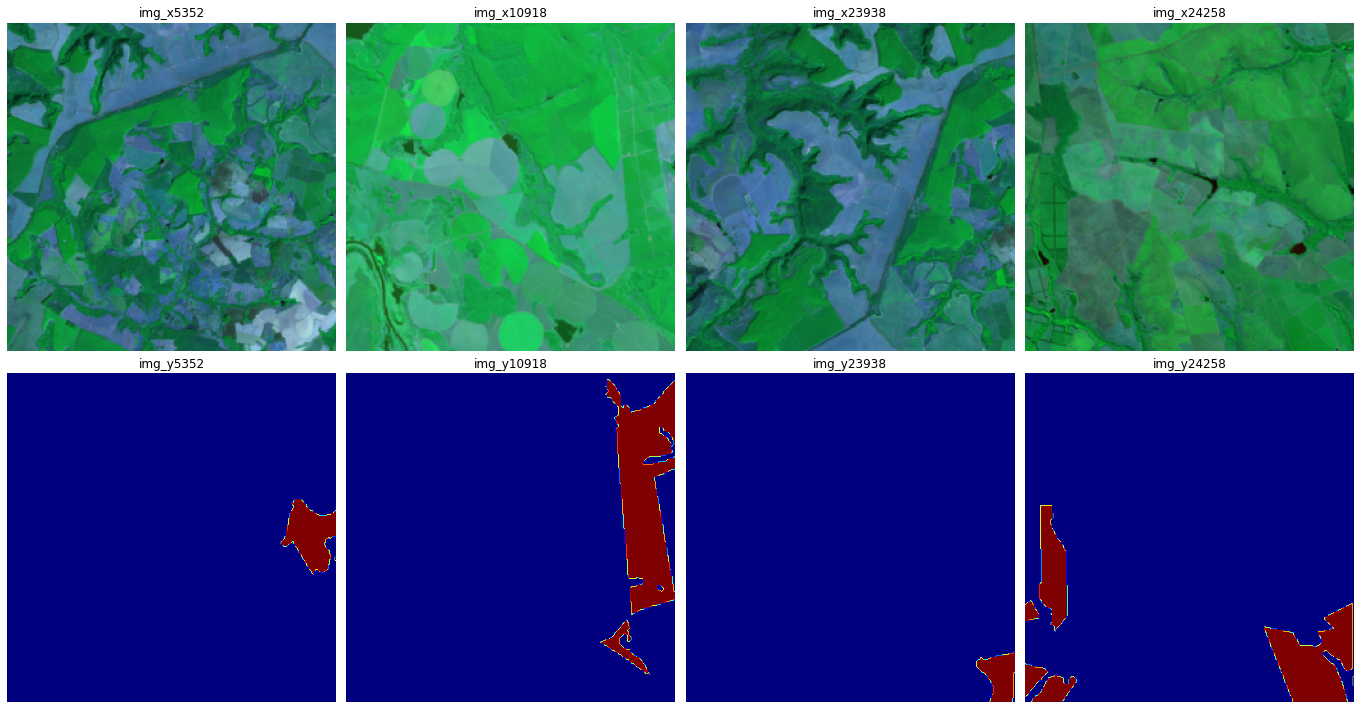

In [ ]:
import matplotlib.pyplot as plt
import random


def plot_figures(figures, nrows = 1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(19, 10))
    for ind,title in zip(range(len(figures)), figures):
        image = figures[title]
        if image.shape[2] == 3:
            axeslist.ravel()[ind].imshow(image, cmap=plt.jet())
        else:
            image = image.reshape((image.shape[0], image.shape[1]))
            axeslist.ravel()[ind].imshow(image)
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

figures = {}

dataset, x, y = load_dataset(TRAIN_PATH, read_only=True)

ids = []

samples = 4

for i in range(0, samples):
    id = random.randint(0,x.shape[0])
    ids.append(id)

for i in ids:
    figures['img_x'+ str(i)] = x[i]

for i in ids:
    figures['img_y'+ str(i)] = y[i]

plot_figures(figures, 2, samples)
dataset.close()

## Train

In [ ]:
model = model_fn((CHIP_SIZE, CHIP_SIZE, CHANNELS))

classifier = Classifier(model=model, model_dir=MODEL_DIR)
 
# in case of error during training, decrease the value of TRAIN_BATCH_SIZE

history = classifier.train(
    input_train=TRAIN_PATH,
    input_validation=VALIDATION_PATH,
    epochs=TRAIN_EPOCHS,
    batch_size=TRAIN_BATCH_SIZE
)
   

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 256, 256, 64) 256         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_23 (Activation)      (None, 256, 256, 64) 0           batch_normalization_23[0][0]     
____________________________________________________________________________________________

## Evaluate your trained model

### Build Test dataset

In [ ]:
import glob

images = [f for f in glob.glob(TEST_DIR + "/*MOSAIC.tif", recursive=True)]

if len(images) == 0:
    print("No test found.")

for image_path in images:
    labels_path = image_path.replace("mosaic", "labels")
    print(image_path)
    print(labels_path)
    generate_test_dataset(
        image_path=image_path,
        labels_path=labels_path,
        test_path=TEST_PATH,
        chip_size=CHIP_SIZE,
        channels=CHANNELS,
        grids=1,
        allow_empty_chip=True
    )

### Run Evaluation

In [ ]:
model = model_fn((CHIP_SIZE, CHIP_SIZE, CHANNELS))

classifier = Classifier(model=model, model_dir=MODEL_DIR)

classifier.evaluate(
    input_test=TEST_PATH,
    batch_size=TRAIN_BATCH_SIZE
)